In [18]:
import os

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

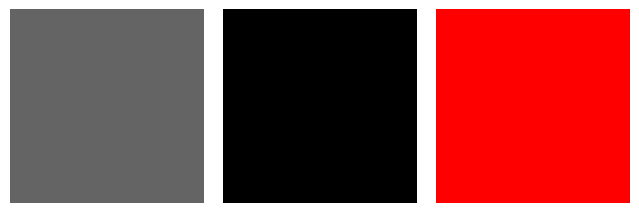

In [19]:
# Create Tile Set
colors = [
    (100,100,100), # gray
    (0,0,0), # black
    (255,0,0), # red
]

base_tiles = []
base_tile_dim = 16
for i in range(len(colors)):
    tile = Image.new("RGB", (base_tile_dim, base_tile_dim))
    for x in range(base_tile_dim):
            for y in range(base_tile_dim):
                tile.putpixel((x, y), colors[i])
    base_tiles.append(tile)

fig, axs = plt.subplots(1, len(colors), figsize=(8, 8))


for col in range(len(colors)):
    axs[col].imshow(base_tiles[col])
    axs[col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

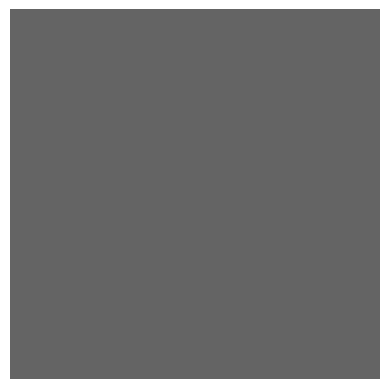

In [20]:
#Create sample image
blocks = [
    [0,0,0,0],
    [0,1,1,1],
    [0,1,2,1],
    [0,1,1,1],
]


image = Image.new("RGB", (16 * len(blocks), 16 * len(blocks)))

for block_row in range(len(blocks)):
    for block_col in range(len(blocks[0])):
         for x in range(16):
            for y in range(16):
                color = base_tiles[blocks[block_row][block_col]].getpixel((x * (base_tile_dim // 16), y * (base_tile_dim // 16)))
                image.putpixel((block_col * 16 + x, block_row * 16 + y), color)

plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

# Extract

In [21]:
overlap_images = []
overlap_blocks = []
overlap_image_dim = 4 * image.size[0] // (len(blocks))
for block_row in range(len(blocks)):
    for block_col in range(len(blocks[0])):
        overlap_block = [
            [blocks[block_row][block_col], blocks[block_row][(block_col + 1) % len(blocks[0])]],
            [blocks[(block_row + 1) % len(blocks)][block_col], blocks[(block_row + 1) % len(blocks)][(block_col + 1) % len(blocks[0])]]
        ]
        overlap_blocks.append(overlap_block)

        overlap_image = Image.new("RGB", (overlap_image_dim,overlap_image_dim))
        for x in range(overlap_image_dim):
            for y in range(overlap_image_dim):
                tile = base_tiles[overlap_block[y // 32][x // 32]]
                color = tile.getpixel((x * (base_tile_dim // overlap_image_dim), y * (base_tile_dim // overlap_image_dim)))
                overlap_image.putpixel((x, y), color)
        overlap_images.append(overlap_image)

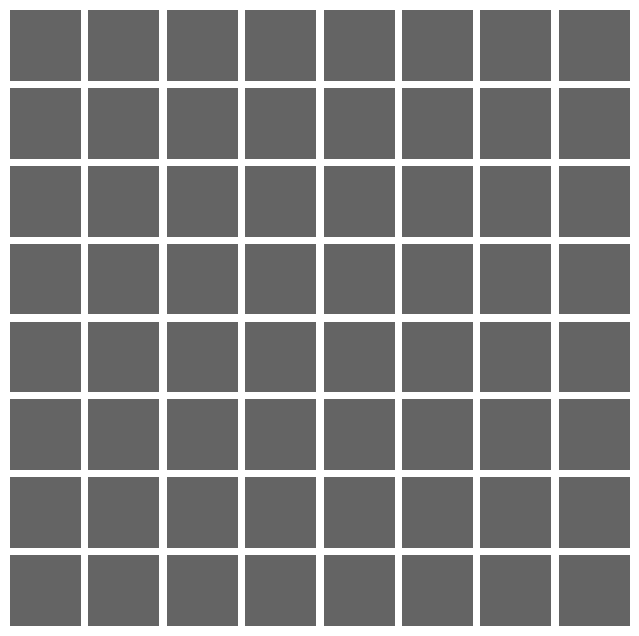

In [22]:
fig, axs = plt.subplots(len(blocks), len(blocks), figsize=(8, 8))

for i in range(len(blocks)):
    for j in range(len(blocks)):
        axs[i, j].imshow(overlap_images[i * len(blocks) + j])
        axs[i, j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

# Initialize

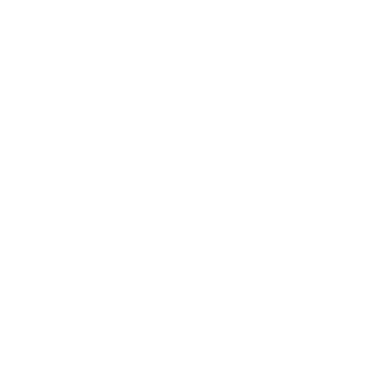

In [23]:
def visualize(grid, size):
    image = Image.new("RGB", (16 * size, 16 * size))
    for row in range(size):
        for col in range(size):
            if len(grid[row][col]) == 1:
                overlap_block_index = grid[row][col][0]
                tile = base_tiles[overlap_blocks[overlap_block_index][0][0]]
                for x in range(16):
                    for y in range(16):
                        color = tile.getpixel((x * (base_tile_dim // 16), y * (base_tile_dim // 16)))
                        image.putpixel((col * 16 + x, row * 16 + y), color)
            else:
                color = (255,255,255)
                for x in range(16):
                    for y in range(16):
                        image.putpixel((col * 16 + x, row * 16 + y), color)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

size = 4
grid = []
for i in range(size):
    grid.append([[i for i in range(len(overlap_images))]] * size)
visualize(grid, size)

# Observe

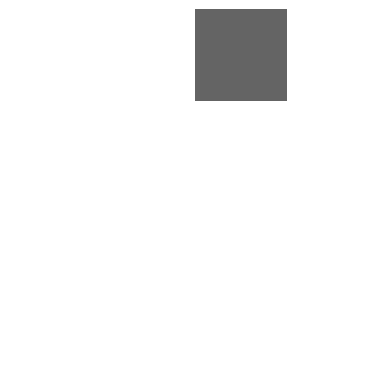

In [24]:
def observe(grid):
    entropies = [len(arr) for row in grid for arr in row if len(arr) > 1]
    if len(entropies) == 0:
        return -1, -1
    min_entropy = min(entropies)

    collapsable_indices = []
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            if len(grid[row][col]) == min_entropy:
                collapsable_indices.append((row, col))

    cell_index = np.random.choice([i for i in range(len(collapsable_indices))])
    row_to_collapse, col_to_collapse = collapsable_indices[cell_index]

    option_index = np.random.choice([i for i in range(len(grid[row_to_collapse][col_to_collapse]))])
    grid[row_to_collapse][col_to_collapse] = [grid[row_to_collapse][col_to_collapse][option_index]]
    return row_to_collapse, col_to_collapse

collapsed_row, collapsed_col = observe(grid)
visualize(grid, size)

# Propagate

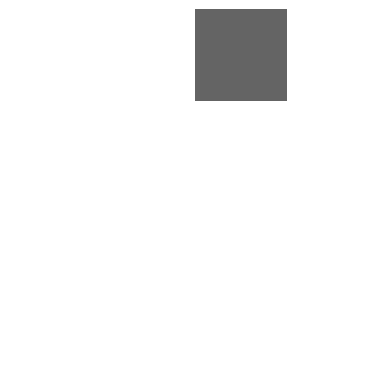

In [25]:
def get_adjacency_rules(options, overlap_blocks, direction):
    self_pixels_to_test = [(0,0), (0,0)]
    other_pixels_to_test = [(0,0), (0,0)]

    if direction == "up":
        self_pixels_to_test = [(0,0), (0,1)]
        other_pixels_to_test = [(1,0), (1,1)]
    elif direction == "right":
        self_pixels_to_test = [(0,1), (1,1)]
        other_pixels_to_test = [(0,0), (1,0)]
    if direction == "down":
        self_pixels_to_test = [(1,1), (1,0)]
        other_pixels_to_test = [(0,1), (0,0)]
    elif direction == "left":
        self_pixels_to_test = [(1,0), (0,0)]
        other_pixels_to_test = [(1,1), (0,1)]

    adjacency_options = set([])
    for option in options:
        pattern = [overlap_blocks[option][self_pixels_to_test[0][0]][self_pixels_to_test[0][1]], overlap_blocks[option][self_pixels_to_test[1][0]][self_pixels_to_test[1][1]]]
        for block_index in range(len(overlap_blocks)):
           check_pattern = [overlap_blocks[block_index][other_pixels_to_test[0][0]][other_pixels_to_test[0][1]], overlap_blocks[block_index][other_pixels_to_test[1][0]][other_pixels_to_test[1][1]]]
           if pattern[0] == check_pattern[0] and pattern[1] == check_pattern[1]:
               adjacency_options.add(block_index)

    return list(adjacency_options)

def propagate(grid, overlap_blocks, collapsed_row, collapsed_col, direction):
    row = 0
    col = 0
    if direction == "up":
        row = collapsed_row - 1
        col = collapsed_col
    elif direction == "right":
        row = collapsed_row
        col = collapsed_col + 1
    if direction == "down":
        row = collapsed_row + 1
        col = collapsed_col
    elif direction == "left":
        row = collapsed_row
        col = collapsed_col - 1

    if row < 0 or col < 0 or row >= len(grid) or col >= len(grid):
        return

    current_options = grid[row][col]
    new_adjacency_options = get_adjacency_rules(grid[collapsed_row][collapsed_col], overlap_blocks, direction)

    new_options = list(set(current_options) & set(new_adjacency_options))
    if len(new_options) == 0:
        raise RuntimeError("No Solution Available")
    if len(new_options) != len(current_options):
        grid[row][col] = new_options
        propagate(grid, overlap_blocks, row, col, "up")
        propagate(grid, overlap_blocks, row, col, "right")
        propagate(grid, overlap_blocks, row, col, "down")
        propagate(grid, overlap_blocks, row, col, "left")

propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "up")
propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "right")
propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "down")
propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "left")
visualize(grid, size)

# All Together

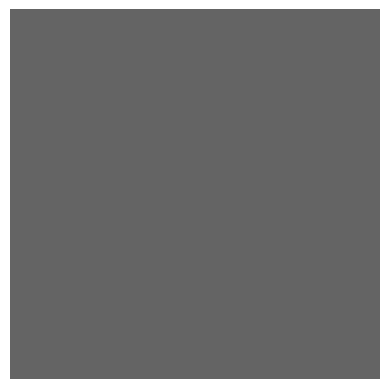

In [26]:
max_attempts = 10
attempt = 0
while True:
    size = 20
    grid = []
    for i in range(size):
        grid.append([[i for i in range(len(overlap_images))]] * size)
    try:
        collapsed_row, collapsed_col = observe(grid)
        while collapsed_row != -1:
            propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "up")
            propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "right")
            propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "down")
            propagate(grid, overlap_blocks, collapsed_row, collapsed_col, "left")

            collapsed_row, collapsed_col = observe(grid)
        break
    except:
        if attempt < max_attempts:
            print("No Solution, Retrying...")
            attempt += 1
        else:
            break
            
visualize(grid, size)
